In [8]:
import warnings
# 仅在这个context里忽略警告
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    from coniii import *
import numpy as np
from tqdm.auto import tqdm
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import random
import Jangenerate_assembly #In the same dir
import Jangenerate_SpikeCount #In the same dir
from scipy.stats import poisson

import itertools
import time
import math

warnings.filterwarnings("ignore")


# Define Parameters
T = 3600 # time of simul“ation
dT = 0.5 # time step
params_assembly_num =5 # number of assemblies
params_point_into_neuron_distance = 0.5 

# Length of an active event as a number of timesteps
eventDur = np.random.randint(1, 10)
# Probability with which a unit is particularly active in a single timestep
eventProb = np.random.uniform(0.01, 0.05)
# Firing rate multiplier at active events
eventMult = np.random.uniform(6, 10)  # random number between 1 and 5
showPlot = False

In [9]:
def binaryOutput(original_list):
    # Create a new list to hold the tuples
    tuples_list = []

    # Generate all possible combinations of two elements for each sublist
    for sublist in original_list:
        combinations = itertools.combinations(sublist, 2)
        # Convert the combinations into tuples and add them to the list
        tuples_list.extend(tuple(sorted(combination)) for combination in combinations)

    # Remove duplicates by converting the list to a set then back to a list
    unique_tuples = list(set(tuples_list))
    
    return unique_tuples

In [10]:
N = [25,36,49,64,81]
params_assembly_density = [n // 6 for n in N] # size of neurons in each assembly

assemblies_list = []
spikeCount_list = []
binary_list = []

for i in tqdm(range (0, len(N))):
    fire_rate_background = np.random.uniform(1, 6, N[i])
    # Here's some preparatory code, we don't count its execution time
    assemblies = Jangenerate_assembly.generate_assembly_solve(N[i], params_assembly_num, params_assembly_density[i])
    # Output 0, 1 type spikes
    spikeCount = Jangenerate_SpikeCount.generateSpikeCountSolve(N[i], T, dT, assemblies, (1, 6), eventDur, eventProb, eventMult, showPlot)
    # Transform to -1, 1 distribution
    spikeCount[spikeCount == 0] = -1
    assemblies_list.append(assemblies)
    spikeCount_list.append(spikeCount)
    
    binary_list.append(binaryOutput(assemblies))

print(assemblies_list)
print()
print(binary_list)

  0%|          | 0/5 [00:00<?, ?it/s]

[[[10, 15, 21], [10, 7, 17], [14, 19], [20, 11, 17], [1, 22, 17, 23]], [[32, 33, 22, 34, 35], [12, 24, 18, 25, 7, 8], [3, 4, 10, 5], [6, 2, 14, 8, 3, 28], [1, 7, 9, 4]], [[19, 34, 27], [30, 17, 31, 10, 32, 27], [44, 37, 38], [44, 45, 46], [28, 21, 35, 15, 22]], [[2, 11, 4, 36, 12, 13, 6], [42, 58, 51, 43, 59, 52, 53], [0, 8, 24, 17, 2, 18, 10, 26], [59, 52, 60, 45, 61, 54, 62], [32, 48, 56, 33, 49, 57, 50, 51]], [[56, 47, 65, 39, 57, 48, 66, 40, 58, 31], [75, 66, 67, 77, 68, 78, 52, 80], [6, 24, 15, 33, 43, 16, 34, 8, 26, 17, 35], [72, 63, 55, 64, 56, 74, 57], [29, 4, 13, 5, 23, 14, 24]]]

[[(10, 15), (10, 21), (15, 21), (7, 17), (11, 20), (17, 20), (17, 23), (7, 10), (10, 17), (1, 22), (22, 23), (1, 17), (1, 23), (14, 19), (17, 22), (11, 17)], [(32, 34), (3, 4), (4, 9), (3, 10), (5, 10), (22, 32), (12, 25), (8, 12), (22, 35), (8, 18), (14, 28), (3, 28), (1, 9), (2, 8), (8, 24), (2, 14), (33, 35), (32, 33), (6, 14), (6, 8), (4, 5), (18, 25), (7, 25), (3, 6), (12, 18), (12, 24), (8, 14)

In [11]:
# Define a function to encapsulate the code you want to time
def code_to_time(spikeCount,threshold):
    solver = ClusterExpansion(spikeCount)
    multipliers, ent, clusters, deltaSdict, deltaJdict= solver.solve(threshold, full_output=True)
    return clusters

In [12]:
# 假设你已经有一个spikeCount_list和threshold
threshold = [0.2, 0.15, 0.1, 0.09, 0.08,0.07]
#threshold = 0.05 does not work

# # 创建一个字典，用于存储每个阈值的结果
results = {thresh: {'accuracy': []} for thresh in threshold}

for thresh in tqdm(threshold):
    iter_ratio = []
    for i in range(len(spikeCount_list)):
        
        # 执行你的函数
        result = code_to_time(spikeCount_list[i], thresh)

        set1 = set([tuple(sublist) for sublist in result[2]])
        set2 = set(binary_list[i])
        # 计算重复度的比率
        if len(set1) == 0:
            dup_ratio = 0
        else:
            dup_ratio = len(set1 & set2) / len(set2)

        iter_ratio.append(dup_ratio)
        print(set1, "--",set2, dup_ratio)
        print("--------------------")

        # 计算平均时间并添加到阈值的结果字典
    results[thresh]['accuracy'].extend(iter_ratio)

  0%|          | 0/5 [00:00<?, ?it/s]

set() -- {(10, 15), (10, 21), (15, 21), (7, 17), (11, 20), (17, 20), (17, 23), (7, 10), (10, 17), (22, 23), (1, 17), (1, 23), (14, 19), (17, 22), (11, 17), (1, 22)} 0
--------------------
{(32, 34), (22, 32), (12, 25), (14, 28), (2, 14), (33, 35), (6, 14), (32, 33), (18, 25), (12, 18), (12, 24), (22, 34), (24, 25), (2, 28), (32, 35), (33, 34), (18, 24), (6, 28), (22, 33), (2, 6)} -- {(32, 34), (3, 4), (4, 9), (3, 10), (5, 10), (22, 32), (12, 25), (14, 28), (3, 28), (8, 12), (22, 35), (8, 18), (1, 9), (2, 8), (8, 24), (2, 14), (33, 35), (32, 33), (6, 14), (6, 8), (4, 5), (18, 25), (7, 25), (3, 6), (12, 18), (12, 24), (8, 14), (22, 34), (7, 9), (24, 25), (7, 12), (2, 28), (32, 35), (33, 34), (7, 18), (7, 24), (18, 24), (3, 5), (6, 28), (4, 10), (3, 8), (3, 14), (4, 7), (22, 33), (34, 35), (1, 4), (2, 3), (1, 7), (2, 6), (8, 28), (8, 25), (7, 8)} 0.38461538461538464
--------------------
{(15, 21), (21, 22), (21, 28), (31, 32), (22, 35), (17, 30), (10, 30), (15, 35), (22, 28), (10, 17), (2

{(24, 33), (67, 68), (58, 65), (67, 77), (31, 47), (66, 78), (31, 56), (68, 75), (31, 65), (24, 26), (24, 35), (14, 24), (31, 40), (4, 23), (48, 56), (48, 65), (66, 80), (31, 58), (68, 77), (15, 16), (47, 48), (16, 24), (47, 57), (16, 33), (47, 66), (6, 34), (5, 14), (23, 29), (6, 43), (5, 23), (48, 58), (16, 17), (8, 34), (55, 63), (8, 43), (16, 26), (55, 72), (16, 35), (77, 78), (52, 67), (40, 47), (75, 78), (40, 56), (66, 75), (13, 14), (13, 23), (33, 35), (77, 80), (23, 24), (66, 68), (57, 65), (4, 29), (52, 78), (40, 58), (66, 77), (75, 80), (72, 74), (56, 57), (63, 72), (15, 34), (26, 34), (4, 13), (15, 43), (14, 23), (26, 43), (31, 39), (57, 58), (52, 80), (17, 34), (17, 43), (47, 56), (64, 72), (63, 74), (6, 15), (47, 65), (6, 24), (6, 33), (5, 13), (4, 24), (8, 15), (39, 48), (8, 24), (34, 43), (39, 57), (8, 33), (39, 66), (40, 65), (6, 8), (47, 58), (6, 17), (6, 26), (55, 74), (6, 35), (52, 66), (52, 75), (75, 77), (8, 17), (8, 26), (8, 35), (24, 34), (58, 66), (24, 43), (35,

{(10, 15), (10, 21), (15, 21), (11, 20), (17, 23), (7, 10), (22, 23), (1, 17), (1, 23), (14, 19), (17, 22), (1, 22)} -- {(10, 15), (10, 21), (15, 21), (7, 17), (11, 20), (17, 20), (17, 23), (7, 10), (10, 17), (22, 23), (1, 17), (1, 23), (14, 19), (17, 22), (11, 17), (1, 22)} 0.75
--------------------
{(32, 34), (4, 9), (3, 10), (5, 10), (22, 32), (12, 25), (3, 28), (8, 12), (8, 18), (14, 28), (22, 35), (1, 9), (2, 8), (2, 14), (8, 24), (6, 8), (6, 14), (32, 33), (33, 35), (4, 5), (7, 25), (3, 6), (18, 25), (12, 18), (12, 24), (8, 14), (22, 34), (7, 9), (24, 25), (2, 28), (7, 12), (32, 35), (33, 34), (7, 18), (7, 24), (3, 5), (6, 28), (18, 24), (4, 10), (3, 14), (22, 33), (1, 4), (34, 35), (2, 3), (1, 7), (2, 6), (8, 28), (8, 25)} -- {(32, 34), (3, 4), (4, 9), (3, 10), (5, 10), (22, 32), (12, 25), (14, 28), (3, 28), (8, 12), (22, 35), (8, 18), (1, 9), (2, 8), (8, 24), (2, 14), (33, 35), (32, 33), (6, 14), (6, 8), (4, 5), (18, 25), (7, 25), (3, 6), (12, 18), (12, 24), (8, 14), (22, 34), 

{(15, 21), (44, 45), (21, 22), (21, 28), (31, 32), (38, 44), (22, 35), (17, 30), (17, 27), (27, 31), (19, 27), (27, 34), (10, 30), (45, 46), (10, 27), (15, 35), (22, 28), (27, 30), (37, 38), (10, 17), (28, 35), (30, 32), (17, 32), (10, 32), (37, 44), (15, 22), (15, 28), (44, 46), (21, 35), (27, 32), (17, 31), (30, 31), (19, 34), (10, 31)} -- {(15, 21), (44, 45), (21, 22), (21, 28), (31, 32), (38, 44), (22, 35), (17, 30), (17, 27), (27, 31), (19, 27), (27, 34), (10, 30), (45, 46), (10, 27), (15, 35), (22, 28), (27, 30), (37, 38), (10, 17), (30, 32), (28, 35), (17, 32), (10, 32), (37, 44), (15, 22), (15, 28), (44, 46), (21, 35), (27, 32), (17, 31), (30, 31), (19, 34), (10, 31)} 1.0
--------------------
{(18, 26), (52, 58), (8, 18), (2, 11), (6, 11), (24, 26), (42, 59), (33, 56), (2, 4), (48, 56), (12, 36), (6, 13), (42, 43), (45, 60), (50, 56), (42, 52), (33, 49), (51, 57), (48, 49), (49, 57), (45, 62), (59, 61), (2, 36), (12, 13), (60, 62), (0, 2), (6, 36), (48, 51), (49, 50), (4, 36), 

In [13]:
results

{0.2: {'accuracy': [0,
   0.38461538461538464,
   0.5882352941176471,
   0.6271186440677966,
   0.6686390532544378]},
 0.1: {'accuracy': [0.3125,
   0.8269230769230769,
   0.8529411764705882,
   0.9830508474576272,
   0.9289940828402367]},
 0.09: {'accuracy': [0.5625,
   0.8846153846153846,
   0.9117647058823529,
   0.9830508474576272,
   0.9289940828402367]},
 0.08: {'accuracy': [0.75,
   0.9230769230769231,
   0.9411764705882353,
   0.9830508474576272,
   0.9940828402366864]},
 0.07: {'accuracy': [0.75, 0.9230769230769231, 1.0, 0.9830508474576272, 1.0]}}

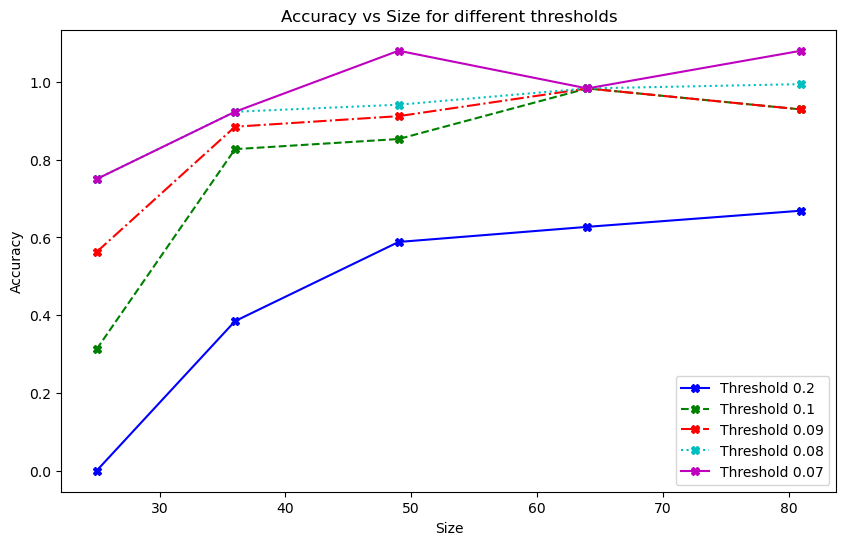

In [16]:
# Different line styles and colors
plt.figure(figsize=(10, 6))

line_styles = ['-', '--', '-.', ':']
colors = ['b', 'g', 'r', 'c', 'm']

for index, (threshold, data) in enumerate(results.items()):
    plt.plot(N, [acc + 0.02 * index if acc == 1.0 else acc for acc in data['accuracy']], line_styles[index % len(line_styles)], color=colors[index % len(colors)], label=f'Threshold {threshold}', marker = "X")

plt.xlabel('Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Size for different thresholds')
plt.legend(loc='lower right')

plt.show()


In [12]:
resultss

{0.8: {'accuracy': [0, 0, 0, 0]}}